# Combined Experiment: Likert Evaluation and Hidden States Collection

This notebook demonstrates how to run an experiment that combines both Likert evaluation with custom labels and the collection of residual stream data for all questions.


In [1]:
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Add the project root to the path to allow imports
repo_root = Path.cwd().parent
if not (repo_root / "abstainer").exists():
    repo_root = Path.cwd()
sys.path.insert(0, str(repo_root))


In [2]:
from abstainer.src.experiment import (
    load_hidden_states,
    run_hidden_states_experiment,
    run_likert_experiment,
)
from abstainer.src.experiment_utils import get_questions_by_filter
from abstainer.src.model import load_model


## 1. Configure the Experiment


In [ ]:
# Experiment configuration
model_id = "google/gemma-3-4b-it"  # Replace with your model
output_dir = Path("./results/combined_experiment")
output_dir.mkdir(parents=True, exist_ok=True)

# Question filters
subject = "Physics"  # Optional: filter by subject
difficulty = None    # Optional: filter by difficulty
split = "train"       # Optional: use train split

# Likert form configuration
form = "V0_letters"  # Likert form to use

# Custom labels for Likert options
# These are the actual tokens the model will generate as responses
# They should be single tokens in the model's vocabulary for best results
custom_labels = [
    "A",  # Definitely Yes
    "B",  # Probably Yes
    "C",  # Not Sure
    "D",  # Probably No
    "E"   # Definitely No
]

# Define output files
likert_output = output_dir / f"likert_results_{form}.json"
hidden_states_output = output_dir / f"hidden_states_{form}.npz"

print(f"Experiment configured with model: {model_id}")
print(f"Subject: {subject}, Split: {split}")
print(f"Using form: {form}")
print(f"Custom labels: {custom_labels}")


Experiment configured with model: google/gemma-3-4b-it
Subject: Physics, Split: train
Using form: V0_letters
Custom labels: ['A', 'B', 'C', 'D', 'E']


## Understanding Custom Labels in Likert Prompts

The `custom_labels` parameter in `run_likert_experiment` allows you to specify the exact tokens that will be used as options in the Likert scale prompt. These tokens are what the model will generate as its response.

For example, with the default "V0_letters" form and custom_labels=["A", "B", "C", "D", "E"], the prompt will look like:

```
Question: Is the Earth round?

A) Definitely yes
B) Probably yes
C) Not sure
D) Probably no
E) Definitely no

Respond with exactly one token.
Answer:
```

The model will then generate one of these tokens as its response. The mapping from these tokens to the universal format (YY, Y, A, N, NN) is handled automatically.

Important notes:
1. The custom labels should ideally be single tokens in the model's vocabulary
2. The order matters: [definitely_yes, probably_yes, not_sure, probably_no, definitely_no]
3. You must provide exactly 5 labels
4. Using tokens that are already in the model's vocabulary will give the best results


## 2. Load Model and Questions


In [4]:
# Load model
print(f"Loading model: {model_id}")
tokenizer, model = load_model(model_id)

# Get questions based on filters
questions = get_questions_by_filter(
    subject=subject,
    difficulty=difficulty,
    split=split
)

print(f"Found {len(questions)} questions matching filters")

# Display a few example questions
for i, q in enumerate(questions[:3]):
    print(f"\nQuestion {i+1}: {q['question']}")
    print(f"ID: {q['id']}, Subject: {q['subject']}, Difficulty: {q['difficulty']}")


Loading model: google/gemma-3-4b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Found 40 questions matching filters

Question 1: Is gravity a force of attraction?
ID: Q-000101, Subject: Physics, Difficulty: 1

Question 2: Is the speed of light constant in a vacuum?
ID: Q-000102, Subject: Physics, Difficulty: 1

Question 3: Is a lever a simple machine?
ID: Q-000104, Subject: Physics, Difficulty: 1


## 3. Run Likert Experiment


In [5]:
# Run Likert experiment
print(f"Running Likert experiment with form '{form}'...")
if custom_labels:
    print(f"Using custom labels: {custom_labels}")

likert_stats = run_likert_experiment(
    model=model,
    tokenizer=tokenizer,
    output_file=str(likert_output),
    questions=questions,
    form=form,
    custom_labels=custom_labels,  # Pass the custom labels to use for Likert options
    verbose=True,
    force_reprocess=True  # Set to False if you want to resume from existing results
)

print(f"\nLikert experiment completed: {likert_stats['completed_questions']} questions processed")
print(f"Average score: {likert_stats.get('average_score')}")
print(f"Score distribution: {likert_stats.get('score_distribution')}")


Running Likert experiment with form 'V0_letters'...
Using custom labels: ['A', 'B', 'C', 'D', 'E']
Processing 40 questions with Likert form 'V0_letters'
Loaded 40 existing results from results/combined_experiment/likert_results_V0_letters.json


100%|██████████| 40/40 [03:26<00:00,  5.16s/it]

Saved 40 results to results/combined_experiment/likert_results_V0_letters.json

Likert experiment completed: 40 questions processed
Average score: 0.8
Score distribution: {'-3': 0, '-2': 7, '-1': 1, '0': 4, '1': 9, '2': 19}


## 4. Collect Hidden States


In [6]:
# Run hidden states experiment
print("Collecting hidden states...")

hidden_stats = run_hidden_states_experiment(
    model=model,
    tokenizer=tokenizer,
    output_file=str(hidden_states_output),
    questions=questions,
    verbose=True,
    force_reprocess=True  # Set to False if you want to resume from existing results
)

print(f"\nHidden states collection completed: {hidden_stats['completed_questions']} questions processed")
print(f"Hidden state shape: {hidden_stats['hidden_state_shape']}")


Processing hidden states for 40 questions


100%|██████████| 40/40 [00:47<00:00,  1.20s/it]


Saved hidden states for 40 questions to results/combined_experiment/hidden_states_V0_letters.npz
Saved metadata to results/combined_experiment/hidden_states_V0_letters.json

Hidden states collection completed: 40 questions processed
Hidden state shape: (35, 2560)


## 5. Save Experiment Configuration


In [7]:
# Save experiment configuration
config = {
    "model_id": model_id,
    "subject": subject,
    "difficulty": difficulty,
    "split": split,
    "form": form,
    "custom_labels": custom_labels,
    "likert_results_file": str(likert_output),
    "hidden_states_file": str(hidden_states_output),
    "likert_stats": likert_stats,
    "hidden_stats": hidden_stats
}

config_file = output_dir / "experiment_config.json"
with open(config_file, 'w', encoding='utf-8') as f:
    json.dump(config, f, indent=2)

print(f"Experiment configuration saved to {config_file}")
print(f"Likert results saved to {likert_output}")
print(f"Hidden states saved to {hidden_states_output}")


Experiment configuration saved to results/combined_experiment/experiment_config.json
Likert results saved to results/combined_experiment/likert_results_V0_letters.json
Hidden states saved to results/combined_experiment/hidden_states_V0_letters.npz


## 6. Analysis Example


In [8]:
# Load the hidden states data
hidden_data = load_hidden_states(str(hidden_states_output))

# Load the Likert results
with open(likert_output, encoding='utf-8') as f:
    likert_results = json.load(f)

print(f"Loaded hidden states for {len(hidden_data['hidden_states'])} questions")
print(f"Loaded Likert results for {len(likert_results)} questions")


Loaded hidden states for 40 questions
Loaded Likert results for 40 questions


Number of correct predictions: 28
Number of incorrect predictions: 8


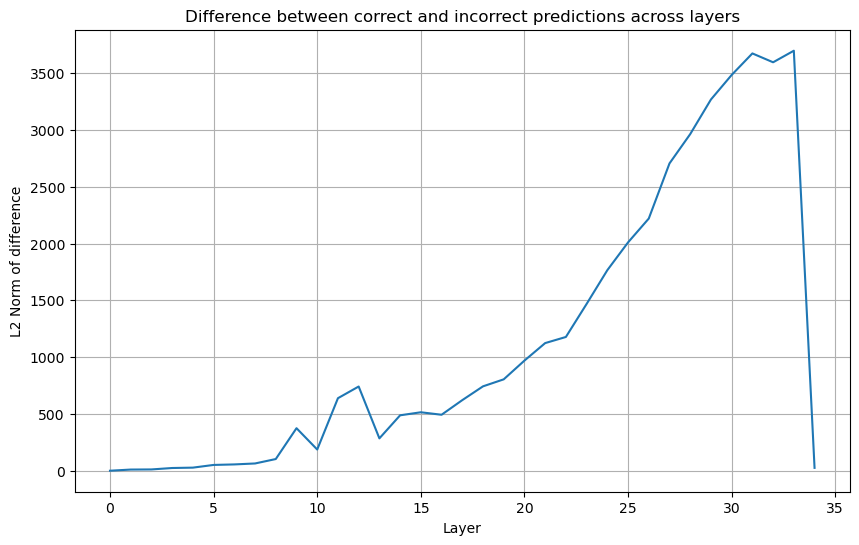

In [9]:
# Example analysis: Compare hidden states for correct vs. incorrect predictions
correct_ids = [qid for qid, result in likert_results.items() if result['score'] > 0]
incorrect_ids = [qid for qid, result in likert_results.items() if result['score'] < 0]

print(f"Number of correct predictions: {len(correct_ids)}")
print(f"Number of incorrect predictions: {len(incorrect_ids)}")

# Function to compute average hidden state across a set of question IDs
def compute_avg_hidden_state(question_ids):
    if not question_ids:
        return None

    # Get hidden states for the specified questions
    hidden_states = [hidden_data['hidden_states'][qid] for qid in question_ids if qid in hidden_data['hidden_states']]

    if not hidden_states:
        return None

    # Stack and average
    return np.mean(np.stack(hidden_states), axis=0)

# Compute average hidden states
avg_correct = compute_avg_hidden_state(correct_ids)
avg_incorrect = compute_avg_hidden_state(incorrect_ids)

if avg_correct is not None and avg_incorrect is not None:
    # Compute difference between correct and incorrect
    diff = avg_correct - avg_incorrect

    # Plot the norm of the difference across layers
    layer_norms = np.linalg.norm(diff, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(layer_norms)
    plt.title("Difference between correct and incorrect predictions across layers")
    plt.xlabel("Layer")
    plt.ylabel("L2 Norm of difference")
    plt.grid(True)
    plt.show()


## 7. Example: Visualize Hidden States for a Specific Question


Question: Is graphene a zero-gap semiconductor?
Answer: Yes
Subject: Physics
Hidden state shape: (35, 2560)
Prediction: A
Score: 0
Probabilities: {'YY': 0.21893708002443493, 'Y': 0.28149053145998776, 'A': 0.3186316432498473, 'N': 0.1700671960904093, 'NN': 0.010873549175320709}


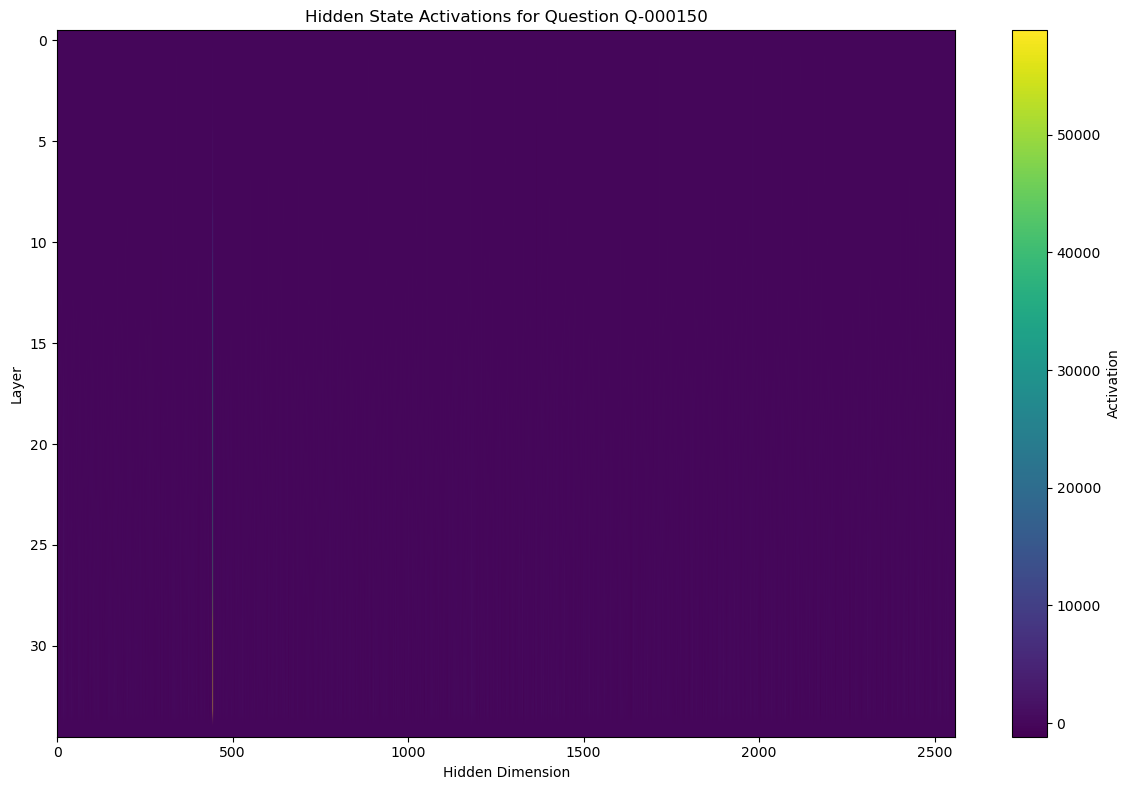

In [13]:
# Pick a question ID
question_ids = list(hidden_data['hidden_states'].keys())
if question_ids:
    qid = question_ids[-1]

    # Get the question metadata and hidden states
    metadata = hidden_data['metadata'][qid]
    hidden_state = hidden_data['hidden_states'][qid]

    print(f"Question: {metadata['question']}")
    print(f"Answer: {metadata['answer']}")
    print(f"Subject: {metadata['subject']}")
    print(f"Hidden state shape: {hidden_state.shape}")

    # Get the Likert prediction
    if qid in likert_results:
        likert_result = likert_results[qid]
        print(f"Prediction: {likert_result['pred_label']}")
        print(f"Score: {likert_result['score']}")
        print(f"Probabilities: {likert_result['probs_norm']}")

    # Visualize the hidden state activations
    plt.figure(figsize=(12, 8))
    plt.imshow(hidden_state, aspect='auto', cmap='viridis')
    plt.colorbar(label='Activation')
    plt.title(f"Hidden State Activations for Question {qid}")
    plt.xlabel("Hidden Dimension")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()
